In [1]:
import sys
import os
if os.getenv('RBMHOME') != None:
    os.chdir(os.getenv('RBMHOME'))
sys.path.append(os.getcwd() + '/src')
sys.path.append(os.getcwd() + '/src/RBMs')
import importlib
import importlib
import torch
from torch.nn.functional import one_hot
import scores
from h5py import File
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from matplotlib import cm
from tqdm import tqdm
import gzip
from matplotlib.colors import to_hex
import h5py
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec

In [2]:
# use LaTeX fonts in the plots
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 15})
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
plt.rcParams['legend.title_fontsize'] = 'xx-small'

In [15]:
# to change
device = torch.device('cuda:1')
model = '/home/lorenzo.rosset/FeF/models/FeF-CMPC-Nh1024.h5'
fname_data = "/home/lorenzo.rosset/FeF/data/CMPC10.h5"
data_name = 'CMPC'
data_set = 'test'
cmap = 'viridis'

#folder_name = f'results/FeF_scores/FeF_scores-{data_name}-Nh300-train'
#os.mkdir(folder_name)
gen_time = 100
num_samples = -1
num_points_trajectory = 50
batch_size = 4457
replication_factor = 2

In [9]:
# import data and RBM model
f_model = File(model, 'r')
f_data = File(fname_data, 'r')

# create the direcory where to store the results if it does not already exist.
model_stamp = f_model['model_stamp'][()].decode('utf8')
# the Potts-RBM requires the input data to be of type int64, while the Bernoulli-RBM requires float32
if 'Potts' in model_stamp:
    data_type = torch.int64
else:
    data_type = torch.float32

# specify the ages of the model to use
alltime = f_model['alltime'][()]
#t_age = alltime[-1]
t_age = 30000

# Import the dataset
allD = torch.tensor(f_data[data_set][()]).type(data_type)
allLabels_string = f_data[data_set + '_labels'].asstr()[()]
if num_samples != -1:
    idxs = np.random.choice(np.arange(allD.shape[0]), num_samples, replace=False)
    allD = allD[idxs].to(device)
    allLabels_string = allLabels_string[idxs]
else:
    allD = allD.to(device)

# Take only the data that have a label
filtered_idxs = np.where((allLabels_string != '-1'))[0]
allLabels_string_filtered = allLabels_string[filtered_idxs]
label2category = {lab : i for i, lab in enumerate(np.unique(allLabels_string_filtered))}
category2label = {i : lab for i, lab in enumerate(np.unique(allLabels_string_filtered))}
labels_data = np.array(([label2category[lab] for lab in allLabels_string_filtered]))
labels_data2counts = {l : c for l, c in zip(*np.unique(labels_data, return_counts=True))}
# Take the labels present in the dataset and repeat them replication_factor times to produce the targets
targets_oversampled = torch.tensor(labels_data, device=device, dtype=torch.int64).repeat(replication_factor)
targets_prediction = torch.tensor(labels_data, device=device) # used for computing the accuracy of the predictions
D = allD[filtered_idxs]
ndata = D.shape[0]
if batch_size > ndata:
    batch_size = -1
    
unique_labels, label_counts = torch.unique(targets_prediction, return_counts=True)
unique_labels = unique_labels.cpu().numpy()
n_categories = unique_labels.shape[0]
print(f'\nExtracted {ndata} labelled samples from the dataset.')
if 'Potts' in model_stamp:
    D_oh = one_hot(D).reshape(ndata, -1).type(torch.float32)
else:
    D_oh = D

# import the proper model
model_identifier = f_model['model_stamp'][()].decode('utf8').split('-')[0]
RBM = importlib.import_module(model_identifier).RBM
rbm = RBM(device=device)
rbm.loadRBM(model, stamp=t_age)
f_data.close()
f_model.close()


Extracted 4457 labelled samples from the dataset.


In [10]:
# compute observables on the dataset
entropy_D_label = {category2label[l] : 0 for l in unique_labels}
for label in unique_labels:
    mask = np.where(labels_data == label)[0]
    entropy_D_label[category2label[label]] = len(gzip.compress(D[mask].int().cpu().numpy())) / len(mask)
    
D_lengths = torch.sum(D != 0, dim=1).cpu().numpy()
D_lengths_mean = D_lengths.mean()
D_lengths_std = D_lengths.std()

# label-specific scores containers: list({label : score_trajectory}) of t_ages
scores_LL = []
scores_spectra = []
scores_AAI = []
scores_entropy = []
scores_AAI_data = []
scores_AAI_gen = []
scores_first_moment = []
scores_second_moment = []

# Define the generation times at which evaluating the model
exponent = int(np.log10(gen_time))
record_times = np.unique(np.logspace(0, exponent, num_points_trajectory).astype(np.int64))
record_times = np.unique(np.sort(np.append([0, rbm.gibbs_steps], record_times)))
# For tracking all the generation process
if num_points_trajectory == gen_time:
    record_times = np.arange(0, num_points_trajectory + 1)
    
# dict(label : score_trajectory)
score_LL_dict = {category2label[l] : [] for l in unique_labels}
score_spectra_dict = {category2label[l] : [] for l in unique_labels}
score_AAI_dict = {category2label[l] : [] for l in unique_labels}
score_entropy_dict = {category2label[l] : [] for l in unique_labels}
score_AAI_data_dict = {category2label[l] : [] for l in unique_labels}
score_AAI_gen_dict = {category2label[l] : [] for l in unique_labels}
score_first_moment_dict = {category2label[l] : [] for l in unique_labels}
score_second_moment_dict = {category2label[l] : [] for l in unique_labels}

In [11]:
G_oversampled = torch.randint(0, rbm.num_states, size=(targets_oversampled.shape[0], D.shape[1]), device=device, dtype=data_type)
predictions = torch.randint(0, rbm.num_categ, (D.shape[0],), device=device, dtype=torch.int64)
pbar = tqdm(desc='Evaluating age {0}'.format(t_age), total=len(record_times) - 1, leave=False, colour='red', dynamic_ncols=True, ascii='-#')
for tg_index in range(1, len(record_times)):
    dt = (record_times[tg_index] - record_times[tg_index - 1])
    G_oversampled, _, _, _ = rbm.conditioned_sampling(G_oversampled, targets_oversampled, it_mcmc=dt, batch_size=batch_size)
    predictions = rbm.predict(D, predictions, it_mcmc=dt, batch_size=batch_size).argmax(-1)
    
    # remove duplicates
    G_oversampled_unique, unique_idxs = np.unique(G_oversampled.cpu().numpy(), axis=0, return_index=True)
    G_oversampled_unique = torch.from_numpy(G_oversampled_unique).to(device) # Caution: as it is, this tensor is sorted, i.e., biased
    targets_oversampled_unique = targets_oversampled[unique_idxs].cpu().numpy()
    
    # extract from the generated set, for each label, the same number of samples present in the datset
    G = []
    gen_labels = []
    gen_labels2count = {l : 0 for l in unique_labels}
    for g, l in zip(G_oversampled_unique, targets_oversampled_unique):
        if not torch.any(torch.all(g == D, dim=1)):
            if gen_labels2count[l] < labels_data2counts[l]:
                G.append(g.unsqueeze(0))
                gen_labels.append(l)
                gen_labels2count[l] += 1
    
    G = torch.cat(G, 0).to(device)
    gen_labels = np.array(gen_labels)
                           
    if 'Potts' in model_stamp:
        G_oh = one_hot(G).reshape(G.shape[0], -1).type(torch.float32)
    else:
        G_oh = G
    
    for label in unique_labels:
        idxs_G = np.where(gen_labels == label)[0]
        idxs_D = np.where(labels_data == label)[0]
        
        if len(idxs_G) >= len(idxs_D):
            random_choice = np.random.choice(np.arange(len(idxs_G)), len(idxs_D), replace=False)
            idxs_G = idxs_G[random_choice]
        else:
            sys.stderr.flush()
            print(f'Warning: label {category2label[label]} has {len(idxs_G)} samples in generated and {len(idxs_D)} samples in data. You may want to increase the replication_factor.')
            random_choice = np.random.choice(np.arange(len(idxs_D)), len(idxs_G), replace=False)
            idxs_D = idxs_D[random_choice]
        
        LL = scores.LL_score_batched_Ssl(D[idxs_D], labels_data[idxs_D], G[idxs_G], gen_labels[idxs_G], rbm, batch_size).cpu()
        score_LL_dict[category2label[label]].append(LL)
        
        spectra = scores.spectrum_score(D_oh[idxs_D], G_oh[idxs_G]).cpu()
        score_spectra_dict[category2label[label]].append(spectra)
        
        AAI_data, AAI_gen = scores.AAI_score(D_oh[idxs_D], G_oh[idxs_G])
        AAI = (AAI_data - 0.5)**2 + (AAI_gen - 0.5)**2
        score_AAI_dict[category2label[label]].append(AAI.cpu().numpy())
        score_AAI_data_dict[category2label[label]].append(AAI_data.cpu().numpy())
        score_AAI_gen_dict[category2label[label]].append(AAI_gen.cpu().numpy())
        
        entropy = scores.entropy_score(entropy_D_label[category2label[label]], G[idxs_G])
        score_entropy_dict[category2label[label]].append(entropy)
        
        first_moment = scores.first_moment_score(D_oh[idxs_D], G_oh[idxs_G]).cpu()
        score_first_moment_dict[category2label[label]].append(first_moment)
        
        second_moment = scores.second_moment_score(D_oh[idxs_D], G_oh[idxs_G]).cpu()
        score_second_moment_dict[category2label[label]].append(second_moment)
    
    pbar.update(1)
record_times = record_times[1:]
sys.stderr.flush()

In [12]:
# save the data
save_data = True
if save_data:
    folder_name = f"/home/lorenzo.rosset/FeF/results/{data_name}/2grad"
    f = h5py.File(folder_name + '/score_LL.h5', 'w')
    for key, value in score_LL_dict.items():
        f[key] = np.array(value)
    f.close()

    f = h5py.File(folder_name + '/score_spectra.h5', 'w')
    for key, value in score_spectra_dict.items():
        f[key] = np.array(value)
    f.close()

    f = h5py.File(folder_name + '/score_entropy.h5', 'w')
    for key, value in score_entropy_dict.items():
        f[key] = np.array(value)
    f.close()

    f = h5py.File(folder_name + '/score_AAI.h5', 'w')
    for key, value in score_AAI_dict.items():
        f[key] = np.array(value)
    f.close()

    f = h5py.File(folder_name + '/score_first_moment.h5', 'w')
    for key, value in score_first_moment_dict.items():
        f[key] = np.array(value)
    f.close()

    f = h5py.File(folder_name + '/score_second_moment.h5', 'w')
    for key, value in score_first_moment_dict.items():
        f[key] = np.array(value)
    f.close()

In [13]:
record_times_ = record_times#[1:]

/tmp/ipykernel_1078665/232622888.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', n_labels)


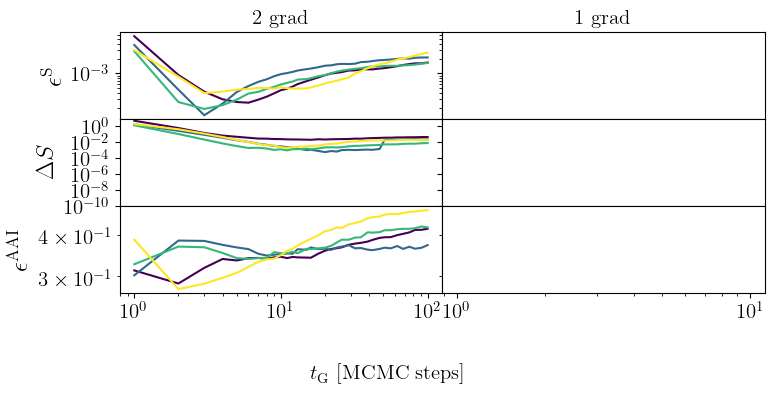

In [17]:
repo1 = f"/home/lorenzo.rosset/FeF/results/{data_name}/Nh200"
#repo2 = f"/home/lorenzo.rosset/FeF/results/{data_name}/1grad"

fig = plt.figure(dpi=100, figsize=(8, 4))
gs = fig.add_gridspec(3, 2, hspace=0, wspace=0)
(ax_spectra1, ax_spectra2), (ax_entropy1, ax_entropy2), (ax_AAI1, ax_AAI2) = gs.subplots(sharex='col', sharey='row')

# spectra
data_2g = h5py.File(repo1 + '/score_spectra.h5', 'r')
#data_1g = h5py.File(repo2 + '/score_spectra.h5', 'r')

n_labels = len(data_2g.keys())
colors = cm.get_cmap('viridis', n_labels)
colors = {lab : to_hex(colors(i)) for i, lab in enumerate(data_2g.keys())}

# 2grad
for label in data_2g.keys():
    ax_spectra1.plot(record_times_, data_2g[label][()], color=colors[label], label=label)
    
# 1grad
#for label in data_1g.keys():
#    ax_spectra2.plot(record_times_, data_1g[label][()], color=colors[label], label=label)

data_2g.close()
#data_1g.close()

#######################################################################################

# Entropy
data_2g = h5py.File(repo1 + '/score_entropy.h5', 'r')
#data_1g = h5py.File(repo2 + '/score_entropy.h5', 'r')

## 2grad
for label in data_2g.keys():
    ax_entropy1.plot(record_times_, data_2g[label][()]**2 + 2e-10, color=colors[label])
    
## 1grad
#for label in data_1g.keys():
#    ax_entropy2.plot(record_times_, data_1g[label][()]**2 + 2e-10, color=colors[label])
    
data_2g.close()
#data_1g.close()

#######################################################################################

# AAI
data_2g = h5py.File(repo1 + '/score_AAI.h5', 'r')
#data_1g = h5py.File(repo2 + '/score_AAI.h5', 'r')

## 2grad
for label in data_2g.keys():
    ax_AAI1.plot(record_times_, data_2g[label][()], color=colors[label])
    
## 1grad
#for label in data_1g.keys():
#    ax_AAI2.plot(record_times_, data_1g[label][()], color=colors[label])
    
data_2g.close()
#data_1g.close()

#######################################################################################

ax_spectra1.set_xscale('log')
ax_spectra1.set_yscale('log')
#ax_spectra1.set_ylim(1e-4)
ax_spectra1.set_ylabel(r'$\epsilon^{\mathrm{S}}$', size=18)
ax_spectra1.set_title('2 grad', size=15)
ax_spectra2.set_title('1 grad', size=15)
ax_spectra2.set_xscale('log')

ax_entropy1.set_yscale('log')
ax_entropy1.set_ylim(1e-10)
ax_entropy1.set_ylabel(r'$\Delta S$', size=18)
#ax_entropy1.axhline(y=0., ls='dashed', color='black', alpha=0.5)
#ax_entropy2.axhline(y=0., ls='dashed', color='black', alpha=0.5)
#ax_entropy3.axhline(y=0., ls='dashed', color='black', alpha=0.5)

ax_AAI1.set_yscale('log')
#ax_AAI1.set_ylim(1e-2)
ax_AAI1.set_ylabel(r'$\epsilon^{\mathrm{AAI}}$', size=18)
fig.supxlabel(r'$t_{\mathrm{G}}$ [MCMC steps]', size=15)

for ax in fig.get_axes():
    ax.label_outer()

ax_spectra1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax_entropy1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax_AAI1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=20))

#h_MNIST, l_MNIST = ax_spectra1.get_legend_handles_labels()
#h_DNA, l_DNA = ax_spectra2.get_legend_handles_labels()
#h_GH30, l_GH30 = ax_spectra3.get_legend_handles_labels()
#h_SAM, l_SAM = ax_spectra4.get_legend_handles_labels()
#fig.gca().add_artist(fig.legend(h_MNIST, l_MNIST, ncol=3, bbox_to_anchor=(0.6,0.5), fontsize=10, title='MNIST - Handwritten digits'))
#fig.gca().add_artist(fig.legend(h_DNA, l_DNA, ncol=2, bbox_to_anchor=(0.6,0.5), fontsize=10, title='HGD - Human genome'))
#fig.gca().add_artist(fig.legend(h_GH30, [l.replace('_', '\_') for l in l_GH30], ncol=3, bbox_to_anchor=(0.6,0.5), fontsize=10, title='GH30 - Protein family'))
#fig.gca().add_artist(fig.legend(h_SAM, [l.replace('_', '\_') for l in l_SAM], ncol=2, bbox_to_anchor=(0.6,0.5), fontsize=10, title='SAM - RNA domain'))
fig.tight_layout()
#fig.savefig('/home/lorenzo.rosset/Documents/drawings/FeF/svg/scores_vs_time_v3.svg')


In [11]:
mean_scores_2grad = {}
mean_scores_1grad = {}

# spectra
data_2g = h5py.File(repo1 + '/score_spectra.h5', 'r')
#data_1g = h5py.File(repo2 + '/score_spectra.h5', 'r')

## 2grad
ms = np.zeros(len(record_times_))
for label in data_2g.keys():
    ms += np.array(data_2g[label][()])
ms /= len(ms)
mean_scores_2grad["spectra"] = ms

## 1grad
ms = np.zeros(len(record_times_))
#for label in data_1g.keys():
#    ms += np.array(data_1g[label][()])
#ms /= len(ms)
#mean_scores_1grad["spectra"] = ms

# Entropy
data_2g = h5py.File(repo1 + '/score_entropy.h5', 'r')
#data_1g = h5py.File(repo2 + '/score_entropy.h5', 'r')

## 2grad
ms = np.zeros(len(record_times_))
for label in data_2g.keys():
    ms += np.array(data_2g[label][()]**2 + 2e-10)
ms /= len(ms)
mean_scores_2grad["entropy"] = ms

## 1grad
ms = np.zeros(len(record_times_))
#for label in data_1g.keys():
#    ms += np.array(data_1g[label][()]**2 + 2e-10)
ms /= len(ms)
mean_scores_1grad["entropy"] = ms

# AAI
data_2g = h5py.File(repo1 + '/score_AAI.h5', 'r')
#data_1g = h5py.File(repo2 + '/score_AAI.h5', 'r')

## 2grad
ms = np.zeros(len(record_times_))
for label in data_2g.keys():
    ms += np.array(data_2g[label][()])
ms /= len(ms)
mean_scores_2grad["AAI"] = ms

## 1grad
ms = np.zeros(len(record_times_))
#for label in data_1g.keys():
#    ms += np.array(data_1g[label][()])
ms /= len(ms)
mean_scores_1grad["AAI"] = ms

data_2g.close()
#data_1g.close()


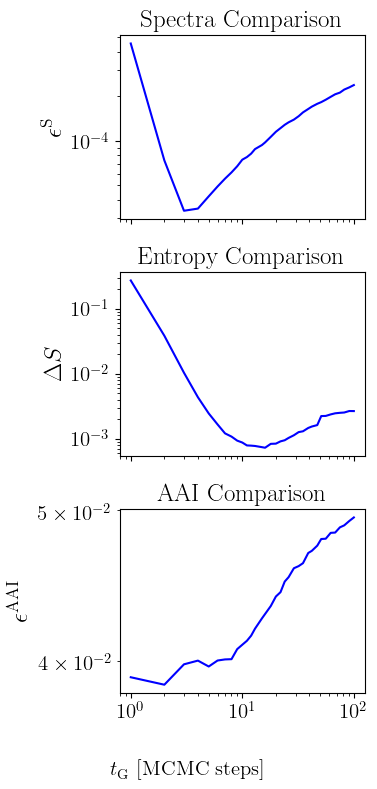

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(4, 8), dpi=100, sharex=True)

# Plot spectra
axs[0].plot(record_times_, mean_scores_2grad["spectra"], label='2 grad', color='blue')
#axs[0].plot(record_times_, mean_scores_1grad["spectra"], label='1 grad', color='orange')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\epsilon^{\mathrm{S}}$', size=18)
#axs[0].legend()
axs[0].set_title('Spectra Comparison')

# Plot entropy
axs[1].plot(record_times_, mean_scores_2grad["entropy"], label='2 grad', color='blue')
#axs[1].plot(record_times_, mean_scores_1grad["entropy"], label='1 grad', color='orange')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$\Delta S$', size=18)
#axs[1].legend()
axs[1].set_title('Entropy Comparison')

# Plot AAI
axs[2].plot(record_times_, mean_scores_2grad["AAI"], label='2 grad', color='blue')
#axs[2].plot(record_times_, mean_scores_1grad["AAI"], label='1 grad', color='orange')
axs[2].set_yscale('log')
axs[2].set_ylabel(r'$\epsilon^{\mathrm{AAI}}$', size=18)
#axs[2].legend()
axs[2].set_title('AAI Comparison')
axs[2].set_xscale('log')

fig.supxlabel(r'$t_{\mathrm{G}}$ [MCMC steps]', size=15)
fig.tight_layout()
plt.show()

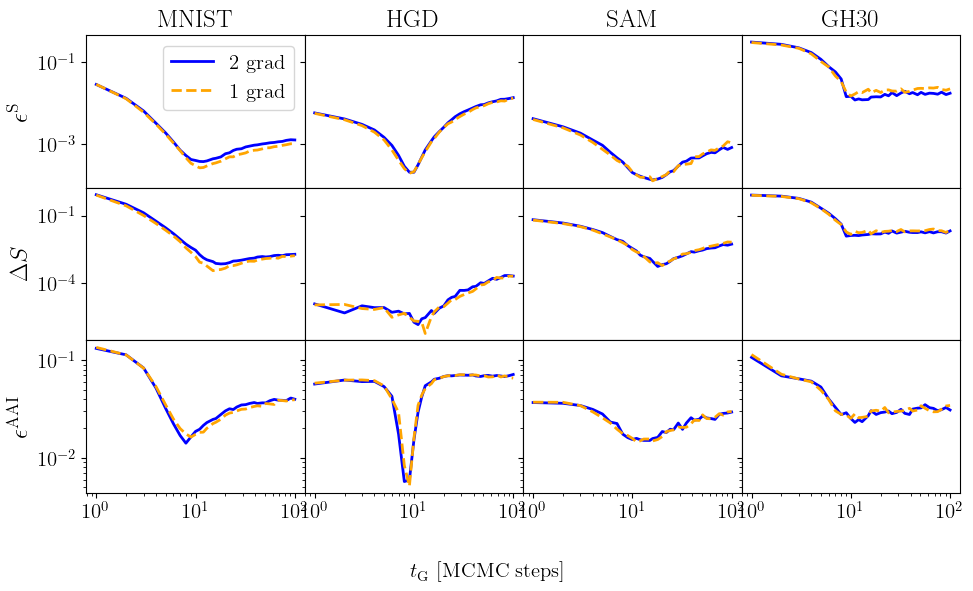

In [18]:
data_names = ["MNIST", "DNA", "SAM", "GH30"]
data_names_map = {
    "MNIST" : "MNIST",
    "DNA" : "HGD",
    "SAM" : "SAM",
    "GH30" : "GH30"
}
linewidth = 2
fig, axs = plt.subplots(3, 4, figsize=(10, 6), dpi=100, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})

for i, data_name in enumerate(data_names):
    repo1 = f"/home/lorenzo.rosset/FeF/results/{data_name}/2grad"
    repo2 = f"/home/lorenzo.rosset/FeF/results/{data_name}/1grad"

    # spectra
    data_2g = h5py.File(repo1 + '/score_spectra.h5', 'r')
    data_1g = h5py.File(repo2 + '/score_spectra.h5', 'r')

    ms_2grad = np.zeros(len(record_times_))
    ms_1grad = np.zeros(len(record_times_))
    for label in data_2g.keys():
        ms_2grad += np.array(data_2g[label][()])
    for label in data_1g.keys():
        ms_1grad += np.array(data_1g[label][()])
    ms_2grad /= len(ms_2grad)
    ms_1grad /= len(ms_1grad)
    axs[0, i].plot(record_times_, ms_2grad, label='2 grad', color='blue', linewidth=linewidth)
    axs[0, i].plot(record_times_, ms_1grad, label='1 grad', color='orange', linestyle='dashed', linewidth=linewidth)

    data_2g.close()
    data_1g.close()

    # entropy
    data_2g = h5py.File(repo1 + '/score_entropy.h5', 'r')
    data_1g = h5py.File(repo2 + '/score_entropy.h5', 'r')

    ms_2grad = np.zeros(len(record_times_))
    ms_1grad = np.zeros(len(record_times_))
    for label in data_2g.keys():
        ms_2grad += np.array(data_2g[label][()]**2 + 2e-10)
    for label in data_1g.keys():
        ms_1grad += np.array(data_1g[label][()]**2 + 2e-10)
    ms_2grad /= len(ms_2grad)
    ms_1grad /= len(ms_1grad)
    axs[1, i].plot(record_times_, ms_2grad, label='2 grad', color='blue', linewidth=linewidth)
    axs[1, i].plot(record_times_, ms_1grad, label='1 grad', color='orange', linestyle='dashed', linewidth=linewidth)

    data_2g.close()
    data_1g.close()

    # AAI
    data_2g = h5py.File(repo1 + '/score_AAI.h5', 'r')
    data_1g = h5py.File(repo2 + '/score_AAI.h5', 'r')

    ms_2grad = np.zeros(len(record_times_))
    ms_1grad = np.zeros(len(record_times_))
    for label in data_2g.keys():
        ms_2grad += np.array(data_2g[label][()])
    for label in data_1g.keys():
        ms_1grad += np.array(data_1g[label][()])
    ms_2grad /= len(ms_2grad)
    ms_1grad /= len(ms_1grad)
    axs[2, i].plot(record_times_, ms_2grad, label='2 grad', color='blue', linewidth=linewidth)
    axs[2, i].plot(record_times_, ms_1grad, label='1 grad', color='orange', linestyle='dashed', linewidth=linewidth)

    data_2g.close()
    data_1g.close()

    axs[0, i].set_title(data_names_map[data_name])
    axs[0, i].set_xscale('log')
    axs[0, i].set_yscale('log')
    axs[1, i].set_yscale('log')
    axs[2, i].set_yscale('log')

axs[0, 0].set_ylabel(r'$\epsilon^{\mathrm{S}}$', size=18)
axs[1, 0].set_ylabel(r'$\Delta S$', size=18)
axs[2, 0].set_ylabel(r'$\epsilon^{\mathrm{AAI}}$', size=18)
fig.supxlabel(r'$t_{\mathrm{G}}$ [MCMC steps]', size=15)

for ax in fig.get_axes():
    ax.label_outer()

    axs[0, 0].legend()

fig.tight_layout()
plt.show()

In [19]:
fig.savefig("/home/lorenzo.rosset/FeF/results/images/1grad_vs_2grad_generation.svg")

## Accuracy vs sampling time

In [11]:
def get_acc_vs_time(fname_model, fname_data, data_type, RBM_type, eval_times):
    f = h5py.File(fname_data, 'r')
    data_set = 'test'
    X_data = torch.tensor(f[data_set][()], device=device, dtype=data_type)
    labels_data_string = f[data_set + '_labels'].asstr()[()]
    lab2num = {l : i for i, l in enumerate(np.unique(labels_data_string))}
    labels_data = torch.tensor([lab2num[l] for l in labels_data_string], device=device, dtype=torch.int64)
    rbm = RBM_type(device=device)
    rbm.loadRBM(fname_model, stamp=30000)
    
    acc_list = np.array([])
    L = torch.randint(0, rbm.num_categ, size=(X_data.shape[0],), device=device).type(torch.int64)
    for tg_index in range(1, len(eval_times)):
        dt = (eval_times[tg_index] - eval_times[tg_index - 1])
        L = rbm.predict(X_data, L, it_mcmc=dt).argmax(-1)
        accuracy = ((labels_data == L).sum() / len(labels_data)).cpu().numpy()
        acc_list = np.append(acc_list, accuracy)
    
    return acc_list

In [12]:
accuracies = {
    "DNA" : {
        "1grad" : [],
        "2grad" : [],    
    },
    "MNIST" : {
        "1grad" : [],
        "2grad" : [],
    },
    "GH30" : {
        "1grad" : [],
        "2grad" : [],
    },
    "SAM" : {
        "1grad" : [],
        "2grad" : [],
    }
}

eval_times = {
    "DNA" : np.unique(np.logspace(0, 3, 50).astype(int)),
    "MNIST" : np.unique(np.logspace(0, 4, 50).astype(int)),
    "SAM" : np.unique(np.logspace(0, 3, 50).astype(int)),
    "GH30" : np.unique(np.logspace(0, 3, 50).astype(int))
}

data_types = {
    "DNA" : torch.float32,
    "MNIST" : torch.float32,
    "SAM" : torch.int64,
    "GH30" : torch.int64,
}

RBMs = {
    "DNA" : "BernoulliBernoulliSslRBM",
    "MNIST" : "BernoulliBernoulliSslRBM",
    "SAM" : "PottsBernoulliSslRBM",
    "GH30" : "PottsBernoulliSslRBM",
}

for data_name in data_names:
    fname_model_1grad = f"/home/lorenzo.rosset/FeF/models/FeF-{data_name}-SingleGrad.h5"
    fname_model_2grad = f"/home/lorenzo.rosset/FeF/models/FeF-{data_name}.h5"
    fname_data = f"/home/lorenzo.rosset/FeF/data/{data_name}.h5"
    RBM = importlib.import_module(RBMs[data_name]).RBM
    acc = get_acc_vs_time(fname_model_1grad, fname_data, data_types[data_name], RBM, eval_times[data_name])
    accuracies[data_name]["1grad"] = acc
    acc = get_acc_vs_time(fname_model_2grad, fname_data, data_types[data_name], RBM, eval_times[data_name])
    accuracies[data_name]["2grad"] = acc

eval_times_All = eval_times["DNA"][1:]
eval_times_MNIST = eval_times["MNIST"][1:]

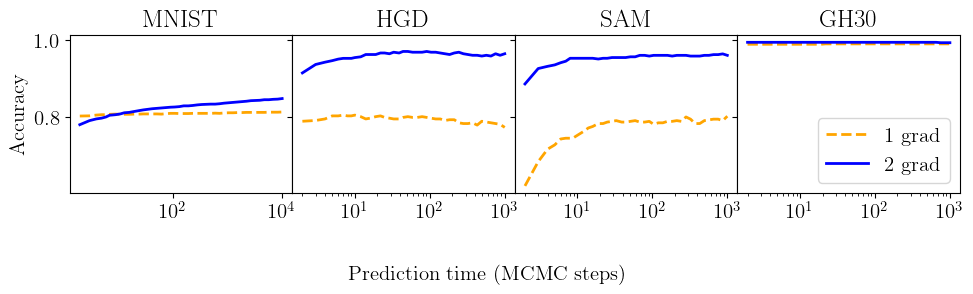

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3), dpi=100, sharey=True, gridspec_kw={'wspace': 0})

for i, data_name in enumerate(data_names):
    eval_times_data = eval_times[data_name][1:]
    axs[i].plot(eval_times_data, accuracies[data_name]["1grad"], label='1 grad', color='orange', ls="dashed", linewidth=2)
    axs[i].plot(eval_times_data, accuracies[data_name]["2grad"], label='2 grad', color='blue', linewidth=2)
    axs[i].set_xscale('log')
    axs[i].set_title(data_names_map[data_name])
    if i == 0:
        axs[i].set_ylabel('Accuracy')
axs[3].legend(loc="lower right")

fig.supxlabel('Prediction time (MCMC steps)', size=15)
fig.tight_layout()
plt.show()

In [54]:
#fig.savefig("/home/lorenzo.rosset/FeF/results/images/1grad_vs_2grad_prediction.svg")

## Accuacy vs training time

In [15]:


device = torch.device('cuda:1')
alltimes = {
    'MNIST' : {
        "1grad" : [],
        "2grad" : [],
    },
    'DNA' : {
        "1grad" : [],
        "2grad" : [],
    },
    'GH30' : {
        "1grad" : [],
        "2grad" : [],
    },
    'SAM' : {
        "1grad" : [],
        "2grad" : [],
    },
}
acc_lists_Rdm = {
    'MNIST' : {
        "1grad" : [],
        "2grad" : [],
    },
    'DNA' : {
        "1grad" : [],
        "2grad" : [],
    },
    'GH30' : {
        "1grad" : [],
        "2grad" : [],
    },
    'SAM' : {
        "1grad" : [],
        "2grad" : [],
    },
}


data_set = 'test'
it_mcmc = 1000

for data_name in data_names:
    fname_data = f"/home/lorenzo.rosset/FeF/data/{data_name}.h5"
    data_type = data_types[data_name]
    RBM = importlib.import_module(RBMs[data_name]).RBM
    f = h5py.File(fname_data, 'r')
    X_data = torch.tensor(f[data_set][()], device=device, dtype=data_type)
    labels_data_string = f[data_set + '_labels'].asstr()[()]
    lab2num = {l : i for i, l in enumerate(np.unique(labels_data_string))}
    labels_data = torch.tensor([lab2num[l] for l in labels_data_string], device=device, dtype=torch.int64)
    fname_model_1grad = f"/home/lorenzo.rosset/FeF/models/FeF-{data_name}-SingleGrad.h5"
    fname_model_2grad = f"/home/lorenzo.rosset/FeF/models/FeF-{data_name}.h5"
    rbm1 = RBM(device=device)
    rbm1.loadRBM(fname_model_1grad)
    rbm2 = RBM(device=device)
    rbm2.loadRBM(fname_model_2grad)
    L_init = torch.randint(0, rbm1.num_categ, size=(X_data.shape[0],), device=device).type(torch.int64)
    alltime1 = rbm1.list_save_rbm
    for t in alltime1[alltime1 < 35000]:
        print(f"Processing {data_name} - 1grad - {t}")
        rbm1.loadRBM(fname_model_1grad, stamp=t)
        predictions_1grad = rbm1.predict(X_data, L_init, it_mcmc=it_mcmc).argmax(-1)
        accuracy_1grad = ((labels_data == predictions_1grad).sum() / len(labels_data)).cpu().numpy()
        acc_lists_Rdm[data_name]["1grad"].append(accuracy_1grad)
        alltimes[data_name]["1grad"].append(t * rbm1.UpdByEpoch)
    alltime2 = rbm2.list_save_rbm
    for t in alltime2[alltime2 < 35000]:
        print(f"Processing {data_name} - 2grad - {t}")
        rbm2.loadRBM(fname_model_2grad, stamp=t)
        predictions_2grad = rbm2.predict(X_data, L_init, it_mcmc=it_mcmc).argmax(-1)
        accuracy_2grad = ((labels_data == predictions_2grad).sum() / len(labels_data)).cpu().numpy()
        acc_lists_Rdm[data_name]["2grad"].append(accuracy_2grad)
        alltimes[data_name]["2grad"].append(t * rbm2.UpdByEpoch)

Processing MNIST - 1grad - 1
Processing MNIST - 1grad - 2
Processing MNIST - 1grad - 4
Processing MNIST - 1grad - 7
Processing MNIST - 1grad - 13
Processing MNIST - 1grad - 22
Processing MNIST - 1grad - 36
Processing MNIST - 1grad - 61
Processing MNIST - 1grad - 103
Processing MNIST - 1grad - 173
Processing MNIST - 1grad - 290
Processing MNIST - 1grad - 485
Processing MNIST - 1grad - 813
Processing MNIST - 1grad - 1361
Processing MNIST - 1grad - 2279
Processing MNIST - 1grad - 3816
Processing MNIST - 1grad - 6390
Processing MNIST - 1grad - 10700
Processing MNIST - 1grad - 17916
Processing MNIST - 1grad - 30000
Processing MNIST - 2grad - 1
Processing MNIST - 2grad - 2
Processing MNIST - 2grad - 3
Processing MNIST - 2grad - 5
Processing MNIST - 2grad - 6
Processing MNIST - 2grad - 7
Processing MNIST - 2grad - 9
Processing MNIST - 2grad - 12
Processing MNIST - 2grad - 15
Processing MNIST - 2grad - 19
Processing MNIST - 2grad - 25
Processing MNIST - 2grad - 31
Processing MNIST - 2grad - 39

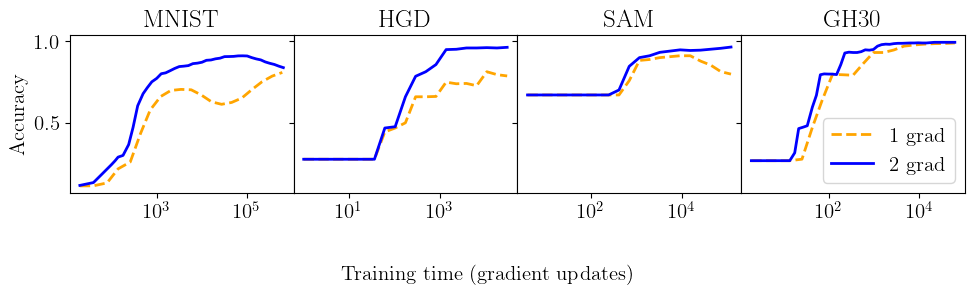

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3), dpi=100, sharey=True, gridspec_kw={'wspace': 0})

for i, data_name in enumerate(data_names):
    times_1grad = alltimes[data_name]["1grad"]
    times_2grad = alltimes[data_name]["2grad"]
    acc_1grad = acc_lists_Rdm[data_name]["1grad"]
    acc_2grad = acc_lists_Rdm[data_name]["2grad"]
    
    axs[i].plot(times_1grad, acc_1grad, label='1 grad', color='orange', linestyle='dashed', linewidth=2)
    axs[i].plot(times_2grad, acc_2grad, label='2 grad', color='blue', linewidth=2)
    axs[i].set_xscale('log')
    axs[i].set_title(data_names_map[data_name])
    if i == 0:
        axs[i].set_ylabel('Accuracy')

axs[3].legend(loc="lower right")

fig.supxlabel('Training time (gradient updates)', size=15)
fig.tight_layout()
plt.show()

In [19]:
fig.savefig("/home/lorenzo.rosset/FeF/results/images/1grad_vs_2grad_training.svg")